# Preparations 

In [1]:
!pip install scanpy 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8046 sha256=96150119ba567da992cab2fbfa46103e4f6549bb3cee4e343831d833666513f0
  Stored in directory: /root/.cache/pip/wheels/e6/3e/d2/2325892469be5cc93dbc1dbe101d0fc48b4765adfb1973b583
Successfully built session-info


In [2]:
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00a 0:00:01


In [3]:
'''!pip install scDeepSort-v1.0-cu102.tar.gz'''

'!pip install scDeepSort-v1.0-cu102.tar.gz'

In [4]:
!pip install celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 11.7 MB/s eta 0:00:0000:0100:01


# Choose one subdataset

In [5]:
dataset="GSM8207629_pat3_pre"


In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dataset.split("_")[0] in os.path.join(dirname, filename):
            print(os.path.join(dirname, filename))

# 'GSM3666101_SC51SSCLOW_barcodes

/kaggle/input/gse263932/GSM8207629_pat3_pre_barcodes.tsv/barcodes.tsv
/kaggle/input/gse263932/GSM8207629_pat3_post_samples.csv/GSM8207629_pat3_post_samples.csv
/kaggle/input/gse263932/GSM8207629_pat3_pre_matrix.mtx/matrix.mtx
/kaggle/input/gse263932/GSM8207629_pat3_pre_features.tsv/features.tsv


# Load barcodes

In [7]:
import pandas as pd

fn = '/kaggle/input/gse263932/'+dataset+'_barcodes.tsv/barcodes.tsv'
obs = pd.read_csv(fn, sep = '\t', index_col = 0, header = None)
obs.index.name = 'Barcode'
# d.columns = ['Gene Symbol']
# d = d.reset_index()
# d = d.set_index('Gene Symbol' )
obs

""
Barcode
AAACCTGAGCGTTGCC-1
AAACCTGAGCTAACAA-1
AAACCTGAGTCAATAG-1
AAACCTGAGTTTAGGA-1
AAACCTGCACGGTGTC-1
...
TTTGTCACATCGTCGG-1
TTTGTCAGTGTGCCTG-1
TTTGTCATCTGATTCT-1


# Load genes information

In [8]:
%%time
fn = '/kaggle/input/gse263932/'+dataset+'_features.tsv/features.tsv'
var = pd.read_csv(fn, sep = '\t', header = None, names=['Gene EnsemblID','Gene Symbol','Description'])
#var.set_index("Gene EnsemblID", drop=True, inplace=True)
'''var.index.name = 'Gene EnsemblID'
var.columns = ['Gene Symbol']'''
var = var.reset_index()
var = var.set_index('Gene Symbol' )
var.drop(var.columns[0], axis=1,inplace=True)
var

CPU times: user 55.2 ms, sys: 10.9 ms, total: 66.1 ms
Wall time: 78.6 ms


,Gene EnsemblID,Description
Gene Symbol,,
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC141272.1,ENSG00000277836,Gene Expression
AC023491.2,ENSG00000278633,Gene Expression
AC007325.1,ENSG00000276017,Gene Expression


# Load main matrix data and attach genes and barcodes to it 

In [9]:
%%time
import scanpy as sc

# Load the .mtx file using Scanpy's read_mtx function
adata = sc.read_mtx("/kaggle/input/gse263932/"+dataset+"_matrix.mtx/matrix.mtx")
adata = adata.T

# Optionally, load the row and column index files
#gene_names = sc.read_text("/kaggle/input/cite-seqscrna-seq-proteins-gse128169/GSM3666101_SC51SSCLOW_genes.tsv/GSM3666101_SC51SSCLOW_genes.tsv", delimiter="\t").squeeze()
#cell_names = sc.read_text("/kaggle/input/cite-seqscrna-seq-proteins-gse128169/GSM3666101_SC51SSCLOW_barcodes.tsv/GSM3666101_SC51SSCLOW_barcodes.tsv").squeeze()

# Assign the row and column index to the AnnData object
adata.var = var
adata.obs = obs
isLogged=False # flag to prevent applying log scale twice
adata


CPU times: user 20.4 s, sys: 554 ms, total: 21 s
Wall time: 22.8 s


AnnData object with n_obs × n_vars = 4266 × 36601
    var: 'Gene EnsemblID', 'Description'

# In case of h5 file

In [10]:
'''import scanpy as sc
adata = sc.read_10x_h5('/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5')'''

"import scanpy as sc\nadata = sc.read_10x_h5('/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5')"

In [11]:
'''import h5py

def print_hdf5_structure(file_name):
    with h5py.File(file_name, 'r') as f:
        def print_attrs(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        f.visititems(print_attrs)

# Replace 'your_file.h5' with the path to your HDF5 file
print_hdf5_structure('/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5')

adata = sc.read_10x_h5('/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5')'''


'import h5py\n\ndef print_hdf5_structure(file_name):\n    with h5py.File(file_name, \'r\') as f:\n        def print_attrs(name, obj):\n            if isinstance(obj, h5py.Dataset):\n                print(f"Dataset: {name}")\n            elif isinstance(obj, h5py.Group):\n                print(f"Group: {name}")\n\n        f.visititems(print_attrs)\n\n# Replace \'your_file.h5\' with the path to your HDF5 file\nprint_hdf5_structure(\'/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5\')\n\nadata = sc.read_10x_h5(\'/kaggle/input/scleroderma-skin-scrna-seq/B/filtered_feature_bc_matrix.h5\')'

# Preprocessing

... storing 'Description' as categorical


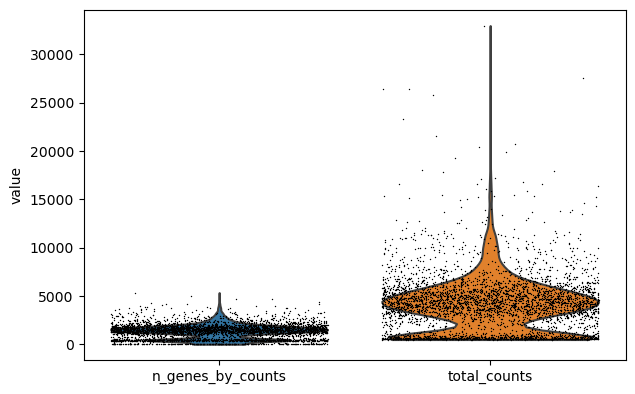

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.var_names_make_unique()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4)

# adata.layers["counts"] is adata after filtering and normalization but before log scaling

In [13]:
!pip install --user magic-impute

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.4 MB/s eta 0:00:0000:01


In [14]:
import scanpy.external as sce

# for exporting signature matrix
sc.pp.filter_cells(data=adata, min_counts=3, inplace=True)
#sc.pp.filter_cells(data=adata, max_counts=25000, inplace=True)
sc.pp.filter_cells(data=adata, min_genes=200, inplace=True)
sc.pp.filter_cells(data=adata, max_genes=2500, inplace=True)

if(isLogged==True):
    print("Data is already logged. Did not perform scaling and transformation again.")
        
else:
    sc.pp.normalize_total(adata, target_sum=1e4)

    adata.layers["counts"]=adata.X.copy()

    sc.pp.log1p(adata)
    #sce.pp.magic(adata, name_list='all_genes', knn=5)
    #
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var_names_make_unique()
    display(adata.to_df().describe())
    isLogged=True

Gene Symbol,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
count,3824.0,3824.0,3824.0,3824.000000,3824.0,3824.0,3824.000000,3824.0,3824.0,3824.0,...,3824.0,3824.0,3824.0,3824.0,3824.0,3824.0,3824.0,3824.0,3824.0,3824.0
mean,0.0,0.0,0.0,0.001771,0.0,0.0,0.007981,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.045417,0.0,0.0,0.120366,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,1.401638,0.0,0.0,2.839257,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


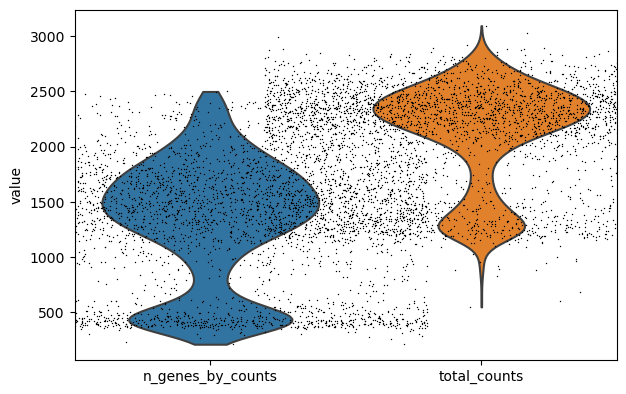

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.8)

In [16]:
import celltypist
model = celltypist.models.Model.load(model = 'Healthy_COVID19_PBMC.pkl')
predictions=celltypist.annotate(adata, model=model, majority_voting=True)
adata.obs["cell_type"]=predictions.predicted_labels["majority_voting"]


In [17]:
'''display(adata.obs.sum())'''

'display(adata.obs.sum())'

In [18]:
sc.pp.highly_variable_genes(adata)
adata.var

,Gene EnsemblID,Description,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
Gene Symbol,,,,,,,,,,,,
MIR1302-2HG,ENSG00000243485,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
FAM138A,ENSG00000237613,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
OR4F5,ENSG00000186092,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
AL627309.1,ENSG00000238009,Gene Expression,6,0.001771,0.001769,99.843096,6.770627,2.050351,False,3.378430e-03,0.851748,-1.113845
AL627309.3,ENSG00000239945,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
AC023491.2,ENSG00000278633,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000
AC007325.1,ENSG00000276017,Gene Expression,0,0.000000,0.000000,100.000000,0.000000,0.000000,False,1.000000e-12,NaN,0.000000


In [19]:
adata.var[adata.var.highly_variable]

,Gene EnsemblID,Description,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
Gene Symbol,,,,,,,,,,,,
AL627309.5,ENSG00000241860,Gene Expression,20,0.007981,0.007949,99.476987,30.517866,3.450555,True,0.025705,2.274022,0.948667
NOC2L,ENSG00000188976,Gene Expression,426,0.147444,0.137537,88.859833,563.826721,6.336519,True,0.340064,2.144582,0.669255
HES4,ENSG00000188290,Gene Expression,37,0.020766,0.020553,99.032427,79.407875,4.387112,True,0.109190,3.045663,2.067664
ISG15,ENSG00000187608,Gene Expression,1657,0.779156,0.576139,56.668410,2979.495361,7.999845,True,1.462152,2.806068,1.079834
AGRN,ENSG00000188157,Gene Expression,19,0.008513,0.008477,99.503138,32.554150,3.513160,True,0.030005,2.372146,1.090962
...,...,...,...,...,...,...,...,...,...,...,...,...
CLIC2,ENSG00000155962,Gene Expression,11,0.006798,0.006775,99.712343,25.995613,3.295674,True,0.030289,2.511176,1.292576
MT-ND5,ENSG00000198786,Gene Expression,3523,2.566883,1.271692,7.871339,9815.766602,9.191847,True,2.979073,3.385051,1.887947
MT-ND6,ENSG00000198695,Gene Expression,2528,1.350210,0.854505,33.891213,5163.205566,8.549506,True,2.082843,4.013184,2.300797


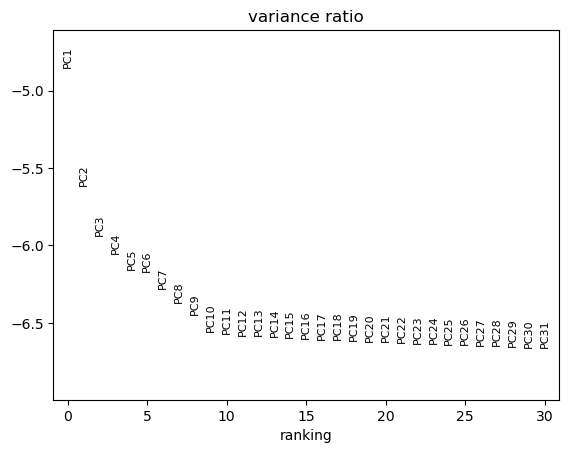

In [20]:
adata.raw=adata
adata=adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata,log=True)

In [21]:
counts_df=pd.DataFrame(adata.layers["counts"].toarray(), index=adata.obs_names, columns=adata.var_names)

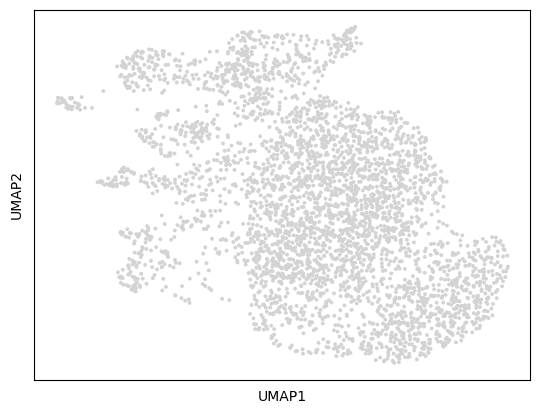

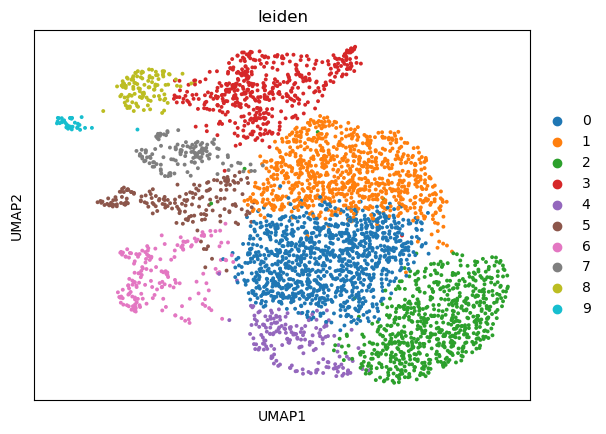

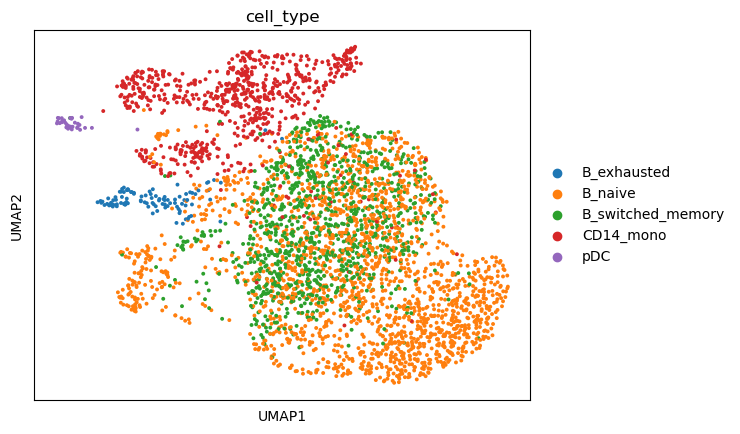

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata)
sc.pl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['cell_type'])

# If you wanna go with unsupervised clustering and not CellTypist

In [23]:
'''adata.obs["cell_type"]=adata.obs["leiden"]'''

'adata.obs["cell_type"]=adata.obs["leiden"]'

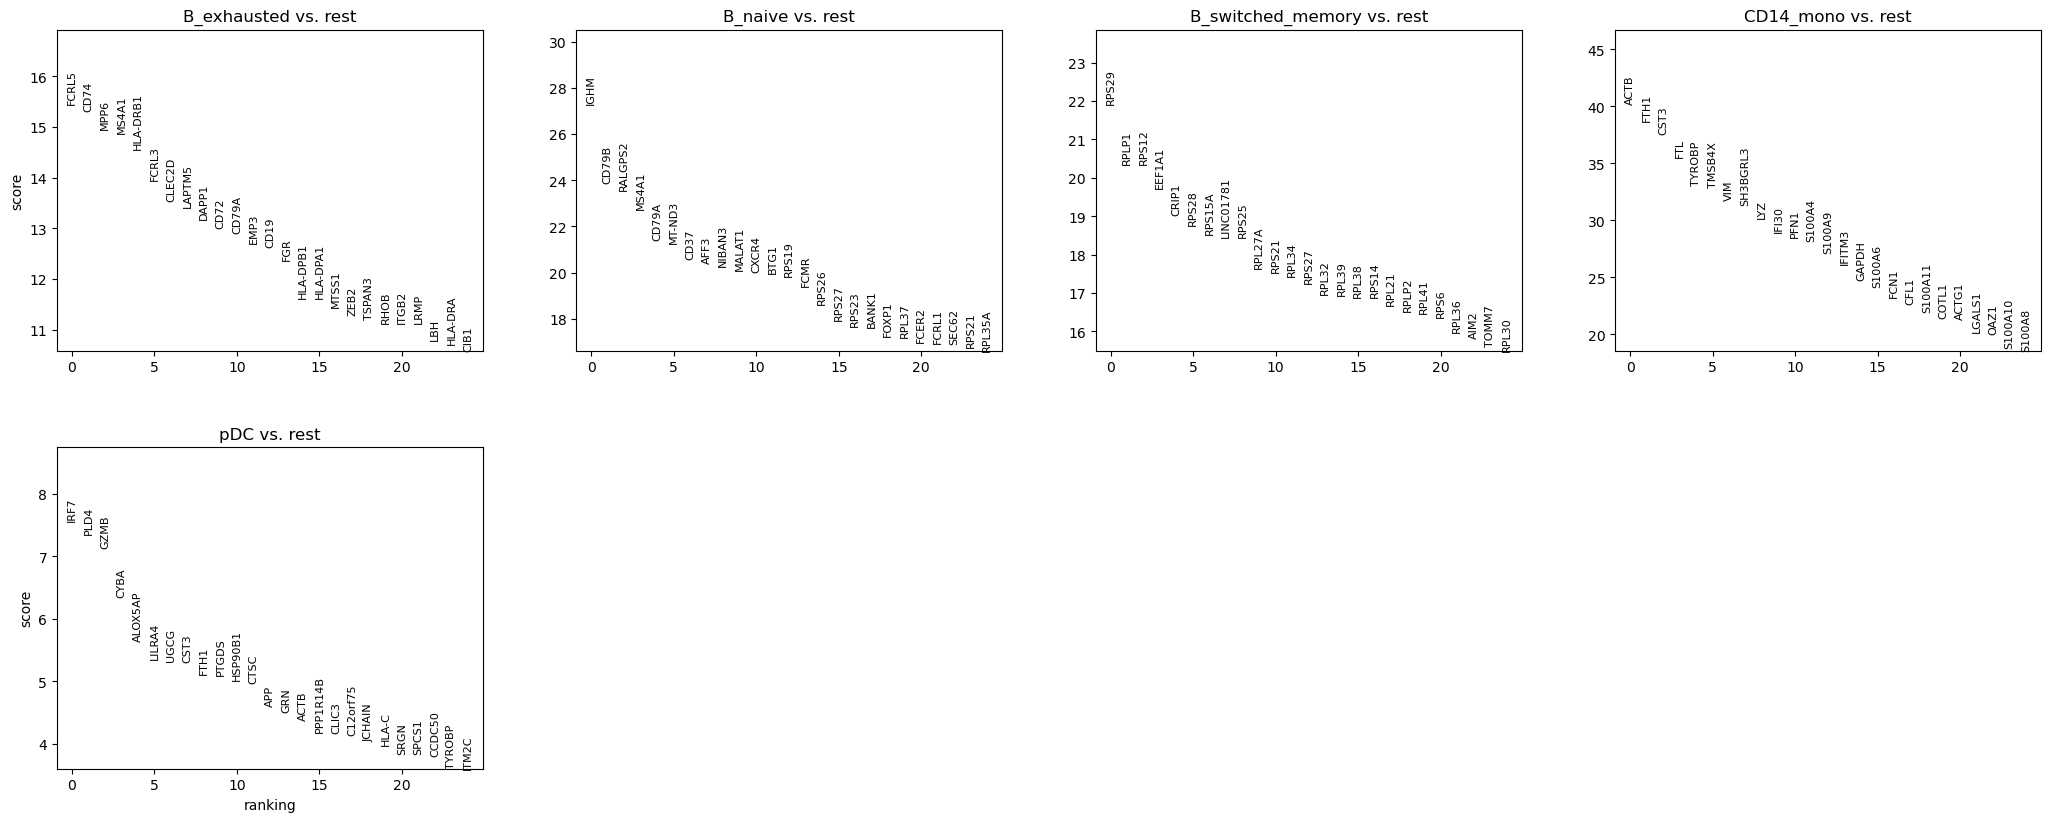

In [24]:
sc.tl.rank_genes_groups(adata, 'cell_type', method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Define a list of proteins that are considered surface markers

In [25]:
cell_locations=pd.read_csv("/kaggle/input/protein-locations/subcellular_location.tsv", sep='\t', header=0)
display(cell_locations)
cell_locations = cell_locations.dropna(subset=["Main location"])
cell_locations = cell_locations[cell_locations["Main location"].str.contains("Plasma membrane")]

surf_markers=cell_locations["Gene name"]
print(surf_markers)

,Gene,Gene name,Reliability,Main location,Additional location,Extracellular location,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id
0,ENSG00000000003,TSPAN6,Approved,Cell Junctions;Cytosol,Nucleoli fibrillar center,NaN,NaN,NaN,Cell Junctions;Cytosol;Nucleoli fibrillar center,NaN,Cytosol,NaN,NaN,Cell Junctions (GO:0030054);Cytosol (GO:000582...
1,ENSG00000000457,SCYL3,Supported,Cytosol;Golgi apparatus,NaN,NaN,NaN,Cytosol;Golgi apparatus,NaN,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Golgi apparatus (GO:0005794)
2,ENSG00000000460,C1orf112,Approved,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739)
3,ENSG00000000938,FGR,Approved,Plasma membrane,Aggresome,NaN,NaN,NaN,Aggresome;Plasma membrane,NaN,NaN,NaN,NaN,Aggresome (GO:0016235);Plasma membrane (GO:000...
4,ENSG00000000971,CFH,Approved,Vesicles,NaN,Predicted to be secreted,NaN,NaN,Vesicles,NaN,NaN,NaN,NaN,Vesicles (GO:0043231)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13142,ENSG00000290292,HOMEZ,Supported,Nucleoli,Cytosol;Nucleoplasm,NaN,NaN,Nucleoli;Nucleoplasm,Cytosol,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Nucleoli (GO:0005730);Nuc...
13143,ENSG00000290315,ENSG00000290315,Approved,Cytosol;Nucleoplasm,Rods & Rings,NaN,NaN,NaN,Cytosol;Nucleoplasm;Rods & Rings,NaN,Cytosol;Rods & Rings,NaN,NaN,Cytosol (GO:0005829);Nucleoplasm (GO:0005654);...
13144,ENSG00000290317,ENSG00000290317,Approved,Nucleoplasm,Golgi apparatus,NaN,NaN,NaN,Golgi apparatus;Nucleoplasm,NaN,NaN,NaN,NaN,Golgi apparatus (GO:0005794);Nucleoplasm (GO:0...
13145,ENSG00000291237,SOD2,Supported,Mitochondria,NaN,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739)


3                    FGR
10                ANKIB1
20                 LASP1
29                 CFLAR
32                SLC7A2
              ...       
13086    ENSG00000285130
13113    ENSG00000285947
13129    ENSG00000288520
13133    ENSG00000288684
13141    ENSG00000290147
Name: Gene name, Length: 1557, dtype: object


# Histograms: Conditional Median and Weighted Median

In [29]:
def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

# finding upregulated proteins in scRNA-seq. Lupus biomarkers adopted from https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2022.941221/full
upregProts_literature=['RSAD2', 'IFIT3', 'APOBEC3A', 'IFIT2', 'PARP9', 'DTX3L', 'PLSCR1', 'IFI35', 'ISG15', 'CMPK2', 'HERC5', 'GBP1', 'IFI27', 'STAT1', 'MX1', 'IRF7', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'IFIH1', 'SIGLEC1', 'LGALS9', 'BST2']
upregProts=intersection(upregProts_literature, adata.var.index)
'''for elem in adata.var.index:
    for p in upregProts:
        if(p == elem):
            print(elem)'''
print("Disease related proteins considered:")
print(upregProts)

Disease related proteins considered:
['PLSCR1', 'LGALS9', 'ISG15', 'OAS3', 'GBP1', 'APOBEC3A', 'IFI27', 'SIGLEC1', 'RSAD2', 'OASL', 'IRF7']


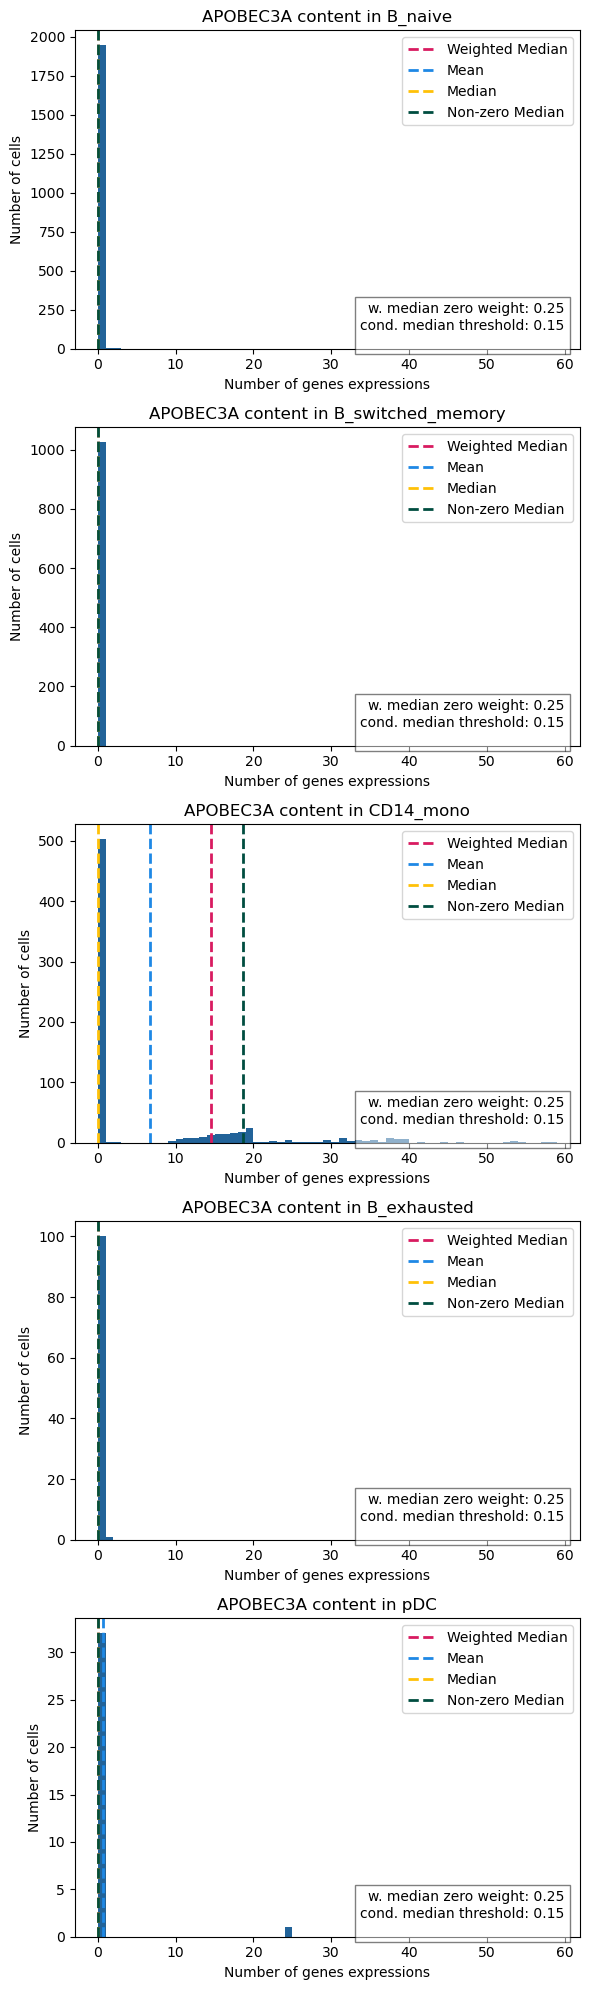

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

upregProt = "APOBEC3A"
zero_weight = 0.25 # for weighted median
conditional_threshold=0.15 # for conditional non zero median

def weighted_median(data, weights):
    """
    Compute the weighted median of data.
    
    Parameters:
    data (array-like): Input data.
    weights (array-like): Weights for each data point.
    
    Returns:
    float: Weighted median.
    """
    data, weights = np.array(data), np.array(weights)
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cumulative_weight = np.cumsum(sorted_weights)
    cutoff = 0.5 * np.sum(sorted_weights)
    return sorted_data[np.where(cumulative_weight >= cutoff)[0][0]]

def conditional_non_zero_median(data, threshold=0.15):
    """
    Compute the median of non-zero values if they constitute more than 
    a given threshold proportion of the total population.
    
    Parameters:
    data (array-like): Input data.
    threshold (float): Proportion threshold for non-zero values.
    
    Returns:
    float: Median of non-zero values if condition is met, otherwise NaN.
    """
    non_zero_vals = data[data > 0]
    if len(non_zero_vals) / len(data) > threshold:
        return np.median(non_zero_vals)
    else:
        return np.nan
    
def conditional_non_zero_median_df(data, threshold=0.15):
    """
    Compute the median of non-zero values for each column in a DataFrame
    if they constitute more than a given threshold proportion of the total population.
    
    Parameters:
    data (DataFrame): Input DataFrame.
    threshold (float): Proportion threshold for non-zero values.
    
    Returns:
    Series: Medians of non-zero values for each column if condition is met, otherwise NaN.
    """
    medians = {}
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            non_zero_vals = data[col][data[col] > 0]
            if len(non_zero_vals) / len(data[col]) > threshold:
                medians[col] = np.median(non_zero_vals)
            else:
                medians[col] = np.nan
        else:
            medians[col] = np.nan
    return pd.Series(medians)


# Uses gene counts per 10,000 cells for score calculation
cellMatrix = pd.DataFrame(adata.layers["counts"].toarray(), index=adata.obs_names, columns=adata.var_names)
cellMatrix['cell_type'] = adata.obs['cell_type']
cellTypes = list(cellMatrix['cell_type'].unique())
fig, axs = plt.subplots(nrows=len(cellTypes), ncols=1, figsize=(6, 4 * len(cellTypes)))

for i, cell_t in enumerate(cellTypes):
    vals = cellMatrix.loc[cellMatrix['cell_type'] == cell_t, upregProt]
    
    # Assign weights: give a lower weight to zero values
    weights = np.ones_like(vals)
    weights[vals == 0] = zero_weight  # Assign a weight of 0.25 to zero values
    
    axs[i].hist(vals, bins=range(0, 60), color='#226399')
    axs[i].set_title(f"{upregProt} content in {cell_t}")
    axs[i].axvline(weighted_median(vals, weights), color='#D81B60', linestyle='dashed', linewidth=2, label='Weighted Median')
    axs[i].axvline(vals.mean(), color='#1E88E5', linestyle='dashed', linewidth=2, label='Mean')
    axs[i].axvline(vals.median(), color='#FFC107', linestyle='dashed', linewidth=2, label='Median')
    non_zero_median=conditional_non_zero_median(vals, threshold=conditional_threshold)
    if not np.isnan(non_zero_median):
        axs[i].axvline(non_zero_median, color='#004D40', linestyle='dashed', linewidth=2, label='Non-zero Median')
    else:
        axs[i].axvline(0, color='#004D40', linestyle='dashed', linewidth=2, label='Non-zero Median')
    axs[i].legend(loc='upper right')
    axs[i].set_xlabel("Number of genes expressions")
    axs[i].set_ylabel("Number of cells")
    axs[i].text(60, 
                0, 
                f"w. median zero weight: {zero_weight:.2f}\ncond. median threshold: {conditional_threshold:.2f}\n", 
                fontsize = 10, 
                bbox = dict(facecolor = 'white', alpha = 0.5),
                horizontalalignment='right',
                verticalalignment='bottom')

plt.tight_layout()
plt.savefig("Mean and Median Modifications.png")
plt.show()


# Heatmap

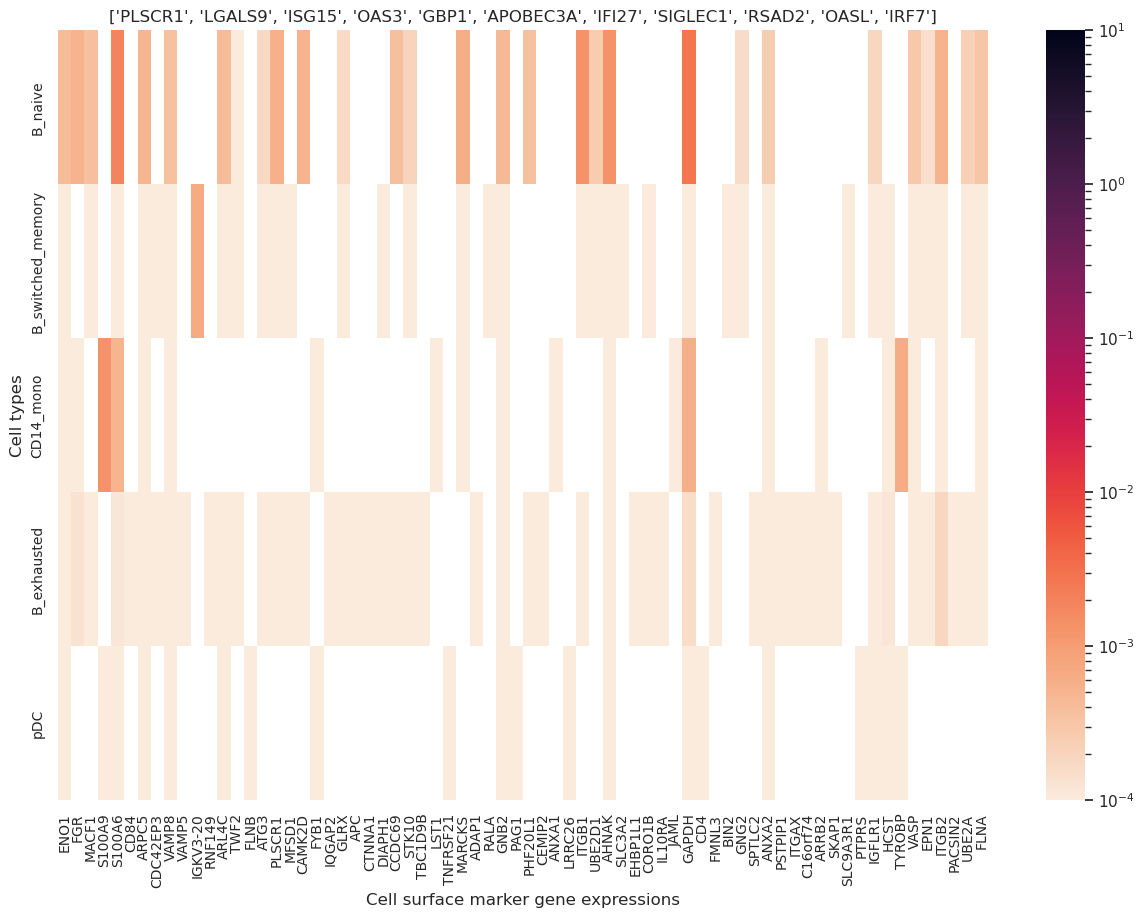

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

averagedMatrix=pd.DataFrame()
sums=[]
for cell_t in cellTypes:
    temp_df= cellMatrix.loc[cellMatrix['cell_type']==cell_t]
    averagedMatrix=averagedMatrix.append(conditional_non_zero_median_df(temp_df), ignore_index=True) # averaging uses conditional non zero median of cell counts
    sums.append(adata.obs.loc[adata.obs["cell_type"]==cell_t,"total_counts"].sum()) # sum number of cells for each cell type
averagedMatrix.index=cellTypes

# normalize counts to make them 0 to 1
for index in cellTypes:
    averagedMatrix.loc[index] = (averagedMatrix.loc[index] - averagedMatrix.loc[index].min()) / (averagedMatrix.loc[index].max() - averagedMatrix.loc[index].min())
'''wholeDf = averagedMatrix.unstack()
wholeDf_range=wholeDf.max()-wholeDf.min() # assuming minimum in whole dataframe is zero
for index in cellTypes:
    averagedMatrix.loc[index] = (averagedMatrix.loc[index]-wholeDf.min()) / wholeDf_range'''
    
sums_norm=sums/sum(sums) #sums are normalized with respect to the total number. In other words, each entry in sums represents that cell type's fraction in that tissue
upregProts_effective=averagedMatrix.loc[:,upregProts].sum(axis=1, numeric_only=True)/len(upregProts)
averagedMatrix=averagedMatrix.mul(upregProts_effective, axis=0) # multiply by upregulated protein presence in each cell type
averagedMatrix=averagedMatrix.mul(sums_norm, axis=0) # multiply by cell type's fraction in tissue

# Filter averagedMatrix to keep only columns that are in surf_markers
markers_averagedMatrix = averagedMatrix.loc[:, averagedMatrix.columns.isin(surf_markers)].copy()

#display(markers_averagedMatrix)
sns.set_theme(style="whitegrid", palette="pastel")
fig,ax=plt.subplots(figsize=(15,10))
norm=LogNorm(vmin=1/10000, vmax=10)
nonzero_markers_averagedMatrix=markers_averagedMatrix.dropna(axis=1, how='all')
sns_plot=sns.heatmap(nonzero_markers_averagedMatrix,ax=ax,cmap='rocket_r', norm=norm,xticklabels=True)

ax.set_title(upregProts)
ax.set(xlabel='Cell surface marker gene expressions', ylabel='Cell types')
#ax.set_xticks(range(len(nonzero_markers_averagedMatrix.columns))) 

#ax.set_xticklabels(nonzero_markers_averagedMatrix.columns) 
sns_plot.tick_params(labelsize=10)
fig.savefig(dataset+"_heatmap.png")

# Targets already used in CAR T-cell therapy

In [35]:
repurposableTargets = [
    "CD80",
    "TNFRSF17",
    "CD22",
    "CD19",
    "NY-ESO-1",
    "CD66e",
    "CD27-L",
    "CLDN18",
    "CD137",
    "CD38",
    "DLL3",
    "EPHA2",
    "EGFR",
    "EGFR vIII",
    "EBV LMP1",
    "HER2",
    "GPRC5D",
    "GCPII",
    "GPC3",
    "PMEL",
    "CD34",
    "ICAM1",
    "IL3RA",
    "CD20",
    "TNFRSF8",
    "MAGEA1",
    "MAGEA4",
    "MSLN",
    "MUC1",
    "CD33",
    "CD371",
    "NCAM1",
    "L1CAM",
    "ROR1",
    "ROR2",
    "MME",
    "KLRK1",
    "PD-L1",
    "PROM1",
    "PSCA",
    "MET",
    "CS1",
    "SDC1",
    "CD7",
    "TRBC1",
    "CD4",
    "TRAIL-R2",
    "EPCAM",
    "KIT"
]

# Violin plots

Top 5 Scores for ['PLSCR1', 'LGALS9', 'ISG15', 'OAS3', 'GBP1', 'APOBEC3A', 'IFI27', 'SIGLEC1', 'RSAD2', 'OASL', 'IRF7']:
Cell type: pDC, Surface marker: IL3RA, Value: 0.0000178	Tested for cancer
Cell type: pDC, Surface marker: CD4, Value: 0.0000140	Tested for cancer
Cell type: B_naive, Surface marker: CD38, Value: nan	Tested for cancer
Cell type: B_switched_memory, Surface marker: CD38, Value: nan	Tested for cancer
Cell type: CD14_mono, Surface marker: CD38, Value: nan	Tested for cancer


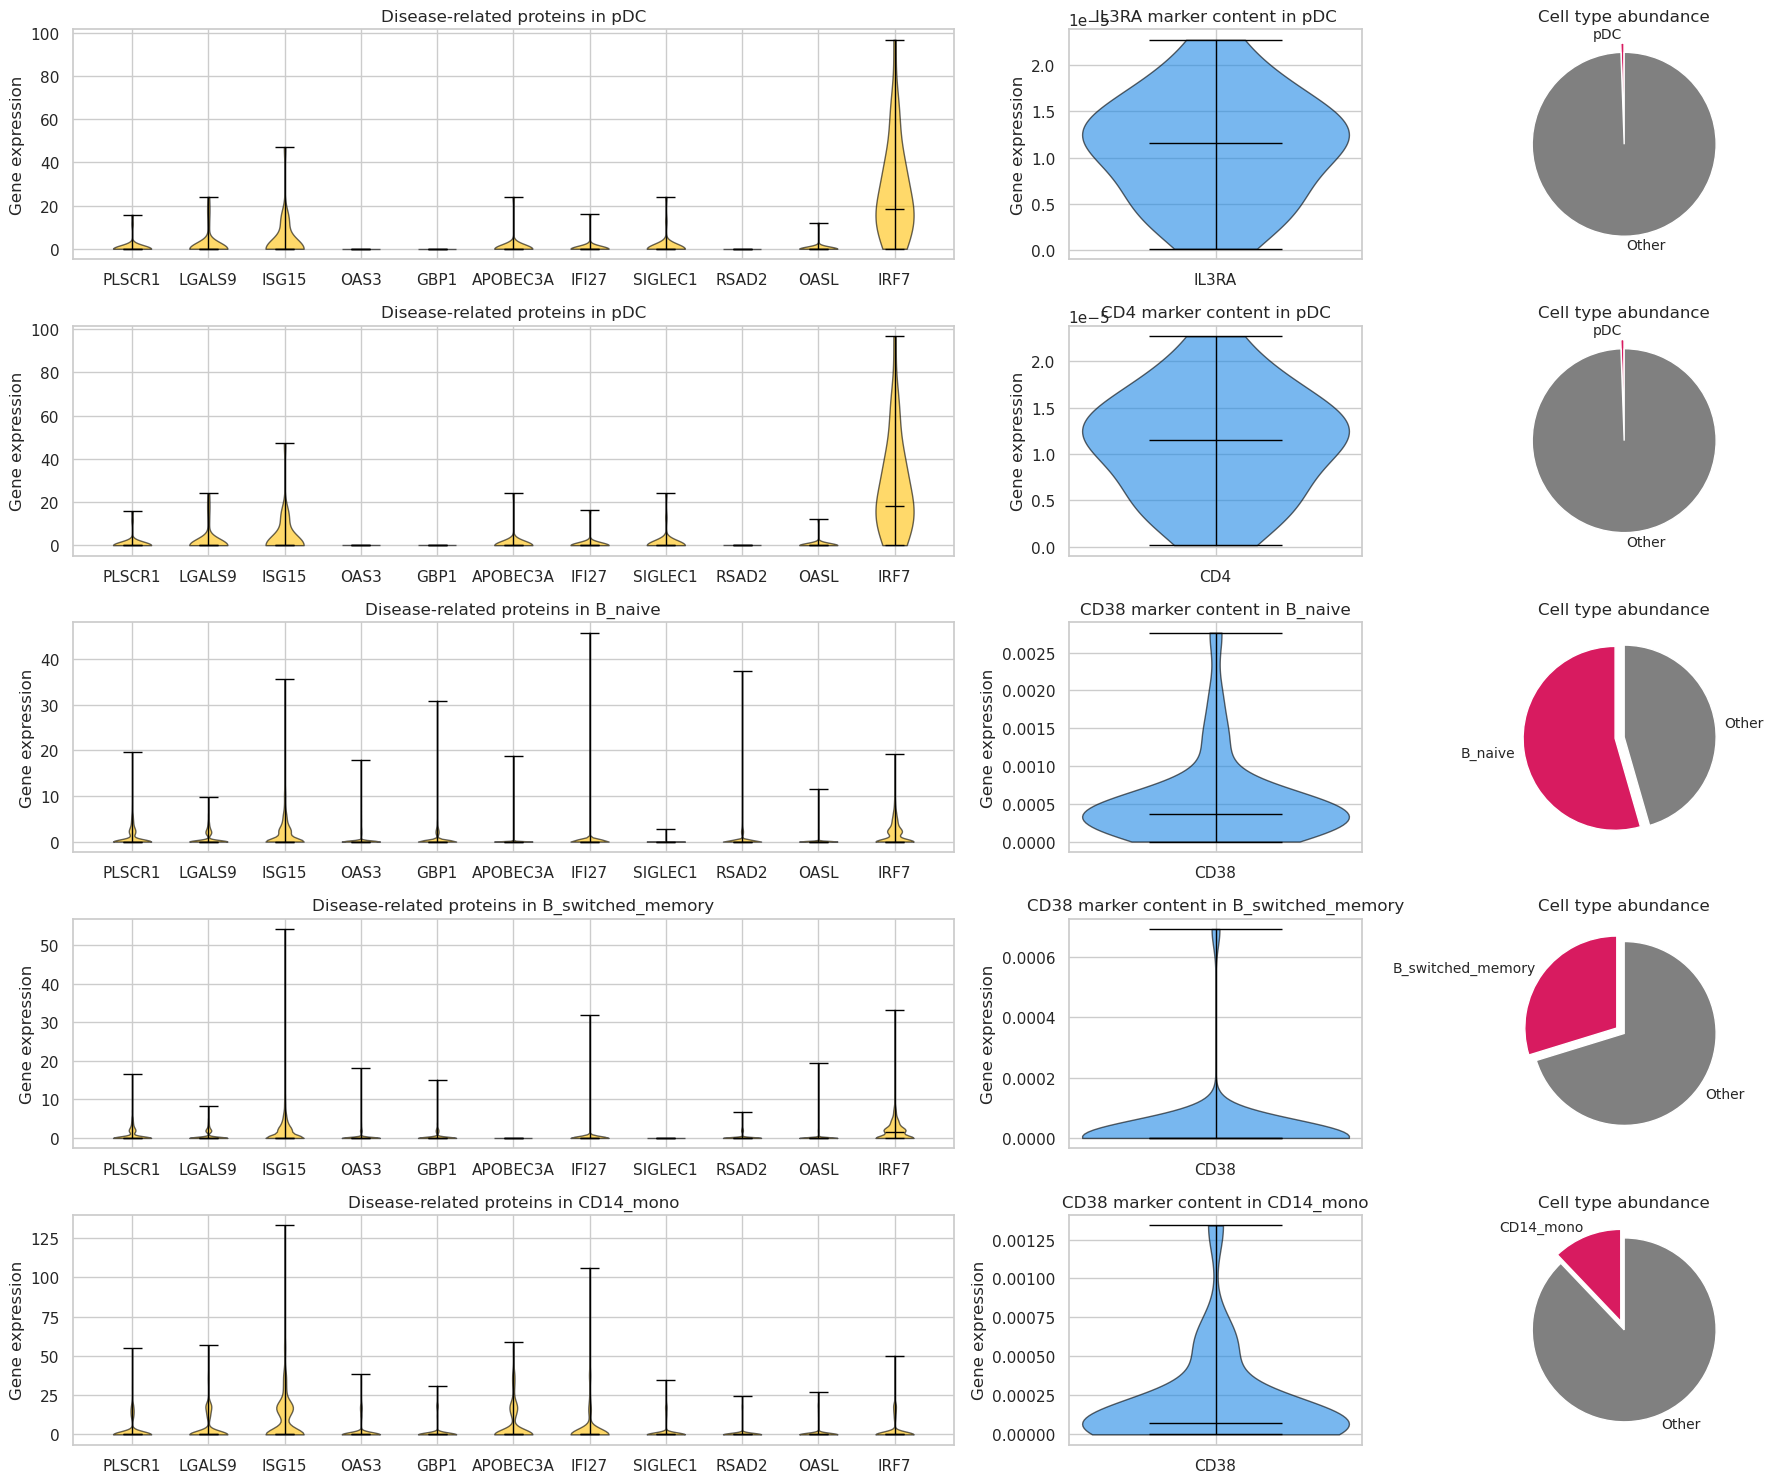

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

only_famous_targets=True

# Assuming the necessary variables (adata, cellMatrix, cellTypes, surf_markers, etc.) are defined elsewhere

# Get top n scores in averagedMatrix with column and index names
if(only_famous_targets):
    usedMarkers_averagedMatrix=averagedMatrix.loc[:, averagedMatrix.columns.isin(repurposableTargets)].copy()
    top_scores = usedMarkers_averagedMatrix.unstack().sort_values(ascending=False).head(n)
else:
    top_scores = markers_averagedMatrix.unstack().sort_values(ascending=False).head(n)
    
top_info = [(index[1], index[0], value) for index, value in top_scores.items()]

# Display the top n scores with column and index names
print("Top " + str(n) + " Scores for " + str(upregProts) + ":")
fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(18, 3*n), gridspec_kw={'width_ratios': [3, 1,1]})
i = 0

for col, idx, val in top_info:
    if idx in repurposableTargets:
        repurp = "\tTested for cancer"
    else:
        repurp = ""

    # Get the data to be plotted in the violin plot
    violin_data_1 = [cellMatrix.loc[cellMatrix['cell_type'] == col, prot] for prot in upregProts]
    violin_data_2 = markers_averagedMatrix.loc[col, :].dropna()

    # Plot the combined violin plot for multiple upregProts
    violin_parts_1 = axs[i, 0].violinplot(violin_data_1, showmedians=True, showextrema=True)
    axs[i, 0].set_xticks(np.arange(1, len(upregProts) + 1))
    axs[i, 0].set_xticklabels(upregProts)
    axs[i, 0].set_title("Disease-related proteins in " + col)
    axs[i, 0].set_ylabel("Gene expression")

    # Customize violin plot colors
    for j, pc in enumerate(violin_parts_1['bodies']):
        pc.set_facecolor('#FFC107')
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = violin_parts_1[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # Plot the second violin plot
    violin_parts_2 = axs[i, 1].violinplot([violin_data_2], showmedians=True, showextrema=True)
    axs[i, 1].set_xticks([1])
    axs[i, 1].set_xticklabels([idx])
    axs[i, 1].set_title(idx + " marker content in " + col)
    axs[i, 1].set_ylabel("Gene expression")

    for pc in violin_parts_2['bodies']:
        pc.set_facecolor('#1E88E5')
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = violin_parts_2[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # Plot the pie chart
    piechart = axs[i, 2].pie([sums_norm[cellTypes.index(col)], 1 - sums_norm[cellTypes.index(col)]],
                             labels=[col, "Other"], colors=['#D81B60', 'grey'],
                             startangle=90, explode=[0.1, 0],
                             textprops={'size': 'smaller'})
    axs[i, 2].set_title("Cell type abundance")

    print(f"Cell type: {col}, Surface marker: {idx}, Value: {val:.7f}" + repurp)
    i += 1

plt.tight_layout()
plt.show()
fig.savefig(dataset + "_" + upregProt + "_violin.png")


In [45]:
import zipfile
import os

zipfile_name=dataset+"_Figures.zip"
directory = "/kaggle/working/"  # The directory to search in

# Find the files that contain the search string
files_to_zip = [f for f in os.listdir(directory) if dataset in f and not "zip" in f]

# Create the zip file and add the filtered files
with zipfile.ZipFile(zipfile_name, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(os.path.join(directory, file), arcname=file)

In [ ]:
#!rm GSM3666108_SC136SSCUP_Figures.zip
